# Prediction Models

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import pydot
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D

### Dropping columns based on Feature Selection

In [64]:
df_old = pd.read_excel('Train Data V3.xlsx', sheet_name = 'New train data')
df_old = df_old.replace({ "No" : False , "Yes" : True })
df_old.drop(columns = "policy_id", inplace = True)

In [65]:
df = df_old[['is_parking_camera',
'transmission_type',
'policy_tenure',
'new_area_cluster',
'is_day_night_rear_view_mirror',
'is_rear_window_wiper',
'age_of_policyholder',
'turning_radius',
'is_rear_window_defogger',
'cylinder',
'rear_brakes_type',
'new_make',
'is_power_steering',
'age_of_car',
'displacement',
'population_density',
'height',
'width',
'is_claim',]]

df = df.replace({ "Disc" : 0 , "Drum" : 1 })
df = df.replace({ "Manual" : 0 , "Automatic" : 1 })

### Balancing the Data 

In [66]:
df_claim = df[df['is_claim'] == True]
df_nonclaim = df[df['is_claim'] == False]
df_nonclaim_sample = df_nonclaim.sample(n=3748,replace=True,random_state=52)
df=pd.concat([df_nonclaim_sample, df_claim])

### Splitting the Data into Test and Train Data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_claim', axis = 1), 
                                                    df.is_claim, test_size=0.3, 
                                                    random_state=52)

## Logistic Regression Model

In [68]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [69]:
testPredictions = model.predict(X_test)

In [70]:
confusion_matrix(y_test, testPredictions)

array([[623, 505],
       [457, 664]])

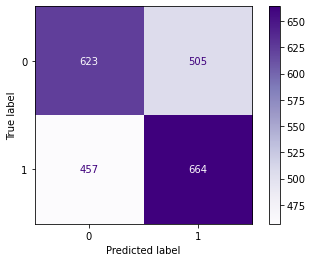

In [71]:
ConfusionMatrixDisplay.from_estimator(model, 
                                      X_test, 
                                      y_test,
                                      cmap = plt.cm.Purples);

In [72]:
accuracy_score(y_test, testPredictions)

0.5722543352601156

In [73]:
print(classification_report(y_test, testPredictions, target_names = ['No Claim', 'Claim']))

              precision    recall  f1-score   support

    No Claim       0.58      0.55      0.56      1128
       Claim       0.57      0.59      0.58      1121

    accuracy                           0.57      2249
   macro avg       0.57      0.57      0.57      2249
weighted avg       0.57      0.57      0.57      2249



In [74]:
testPredictionProbs = model.predict_proba(X_test)

In [75]:
testPredictionProbs[:10,]

array([[0.55071856, 0.44928144],
       [0.37470212, 0.62529788],
       [0.36607102, 0.63392898],
       [0.50743101, 0.49256899],
       [0.5540423 , 0.4459577 ],
       [0.3826976 , 0.6173024 ],
       [0.52814393, 0.47185607],
       [0.63063302, 0.36936698],
       [0.3721017 , 0.6278983 ],
       [0.37303479, 0.62696521]])

### Using predictions above 25% only

In [15]:
testPredsCustomCutoff = np.where(testPredictionProbs[:, 1] > 0.25, 1, 0)
testPredsCustomCutoff[:5]

array([1, 1, 1, 1, 1])

In [16]:
confusion_matrix(y_test, testPredsCustomCutoff)

array([[   0, 1128],
       [   0, 1121]])

In [17]:
accuracy_score(y_test, testPredsCustomCutoff)

0.49844375277901287

In [18]:
print(classification_report(y_test, testPredictions, target_names = ['No Claim', 'Claim']))

              precision    recall  f1-score   support

    No Claim       0.58      0.55      0.56      1128
       Claim       0.57      0.59      0.58      1121

    accuracy                           0.57      2249
   macro avg       0.57      0.57      0.57      2249
weighted avg       0.57      0.57      0.57      2249



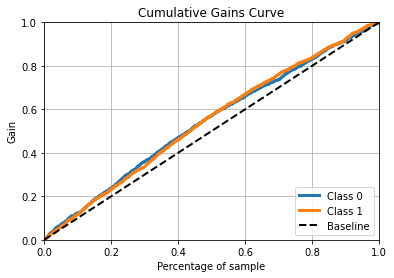

In [19]:
plot_cumulative_gain(y_test, testPredictionProbs);

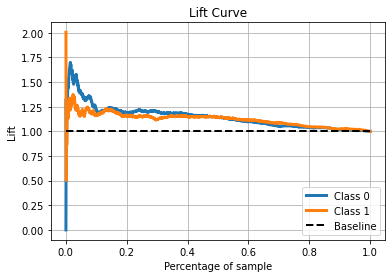

In [20]:
plot_lift_curve(y_test, testPredictionProbs);

,Lift,N,Cumulative N,Cumulative Percentile
"(0.312, 0.386]",0.776,225,2249,100
"(0.386, 0.412]",0.856,225,2024,90
"(0.412, 0.44]",0.767,225,1799,80
"(0.44, 0.473]",0.909,225,1574,70
"(0.473, 0.505]",0.972,225,1349,60
"(0.505, 0.54]",1.120,224,1124,50
"(0.54, 0.56]",1.239,225,900,40
"(0.56, 0.582]",1.043,225,675,30
"(0.582, 0.615]",1.150,225,450,20
"(0.615, 0.659]",1.168,225,225,10


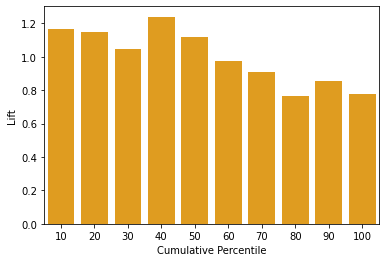

In [21]:
import seaborn as sns

testOutcomes = pd.DataFrame({
  'Actuals': y_test.astype('int'), 
  'Probs': testPredictionProbs[:, 1]
})

cuts = pd.qcut(testOutcomes.Probs, q = 10, duplicates = 'drop') 
lifts = (testOutcomes.groupby(cuts)['Actuals'].sum() / cuts.value_counts()) / np.mean(testOutcomes.Actuals)

plotDat = pd.DataFrame({
  'Lift': np.round(lifts, 3),
  'N': cuts.value_counts()
})

plotDat['Cumulative N'] = np.cumsum(np.flip(plotDat.N))
plotDat['Cumulative Percentile'] = round(plotDat['Cumulative N'] / len(testOutcomes) * 100, 0).astype('int')

sns.barplot(y = 'Lift', 
            x = 'Cumulative Percentile', 
            data = plotDat, 
            color = 'orange');

plotDat

In [22]:
roc_auc_score(y_test, testPredictionProbs[:, 1])

0.585914615243482

## Decision Tree Model

In [23]:
model = DecisionTreeClassifier(max_depth = 3, random_state = 321)
basicFit = model.fit(X_train, y_train);

[Text(0.5, 0.875, 'x[2] <= 0.369\ngini = 0.5\nsamples = 5247\nvalue = [2620, 2627]'),
 Text(0.25, 0.625, 'x[13] <= 0.005\ngini = 0.469\nsamples = 1593\nvalue = [995, 598]'),
 Text(0.125, 0.375, 'x[14] <= 897.0\ngini = 0.477\nsamples = 377\nvalue = [148, 229]'),
 Text(0.0625, 0.125, 'gini = 0.438\nsamples = 302\nvalue = [98, 204]'),
 Text(0.1875, 0.125, 'gini = 0.444\nsamples = 75\nvalue = [50, 25]'),
 Text(0.375, 0.375, 'x[2] <= 0.222\ngini = 0.423\nsamples = 1216\nvalue = [847, 369]'),
 Text(0.3125, 0.125, 'gini = 0.389\nsamples = 783\nvalue = [576, 207]'),
 Text(0.4375, 0.125, 'gini = 0.468\nsamples = 433\nvalue = [271, 162]'),
 Text(0.75, 0.625, 'x[2] <= 0.678\ngini = 0.494\nsamples = 3654\nvalue = [1625, 2029]'),
 Text(0.625, 0.375, 'x[2] <= 0.389\ngini = 0.5\nsamples = 1006\nvalue = [511, 495]'),
 Text(0.5625, 0.125, 'gini = 0.423\nsamples = 56\nvalue = [17, 39]'),
 Text(0.6875, 0.125, 'gini = 0.499\nsamples = 950\nvalue = [494, 456]'),
 Text(0.875, 0.375, 'x[6] <= 0.351\ngini = 0

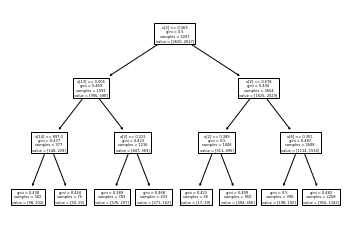

In [24]:
tree.plot_tree(basicFit)

In [25]:
y_score1 = model.predict_proba(X_test)[:,1]

In [26]:
yPred = model.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test,yPred)
report = classification_report(yPred, y_test)
cm = confusion_matrix(y_test, yPred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm) 

Classification report:
Accuracy:  0.5700311249444198
              precision    recall  f1-score   support

           0       0.58      0.57      0.57      1139
           1       0.56      0.57      0.57      1110

    accuracy                           0.57      2249
   macro avg       0.57      0.57      0.57      2249
weighted avg       0.57      0.57      0.57      2249

Confusion matrix:
[[650 478]
 [489 632]]


### ROC Curve

In [28]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))

roc_auc_score for DecisionTree:  0.6077985714376095


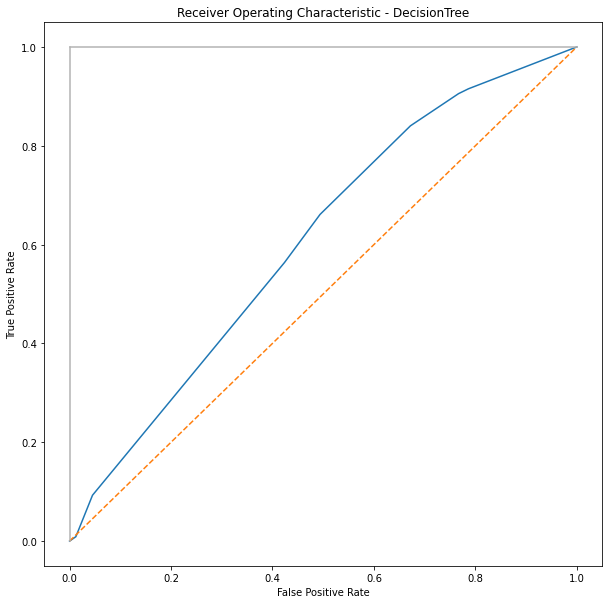

In [29]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Removing the Root Node

In [30]:
dfsample2 = df.drop('policy_tenure', axis='columns')

In [31]:
X_train1, X_test1, y_train, y_test = train_test_split(dfsample2.drop('is_claim', axis = 1), 
                                                    dfsample2.is_claim, test_size=0.3, 
                                                    random_state=52)

In [32]:
model2 = DecisionTreeClassifier(max_depth = 3, random_state = 321)
basicFit2 = model2.fit(X_train1, y_train)

In [33]:
y_score2 = model2.predict_proba(X_test1)[:,1]

In [34]:
yPred2 = model2.predict(X_test1)

In [35]:
accuracy = accuracy_score(y_test,yPred2)
report = classification_report(yPred2, y_test)
cm = confusion_matrix(y_test, yPred2)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5371276122721209
              precision    recall  f1-score   support

           0       0.36      0.56      0.44       715
           1       0.72      0.53      0.61      1534

    accuracy                           0.54      2249
   macro avg       0.54      0.54      0.52      2249
weighted avg       0.60      0.54      0.55      2249

Confusion matrix:
[[401 727]
 [314 807]]


In [36]:
false_positive_rate2, true_positive_rate2, threshold1 = roc_curve(y_test, y_score2)
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score2))

roc_auc_score for DecisionTree:  0.5619677687728156


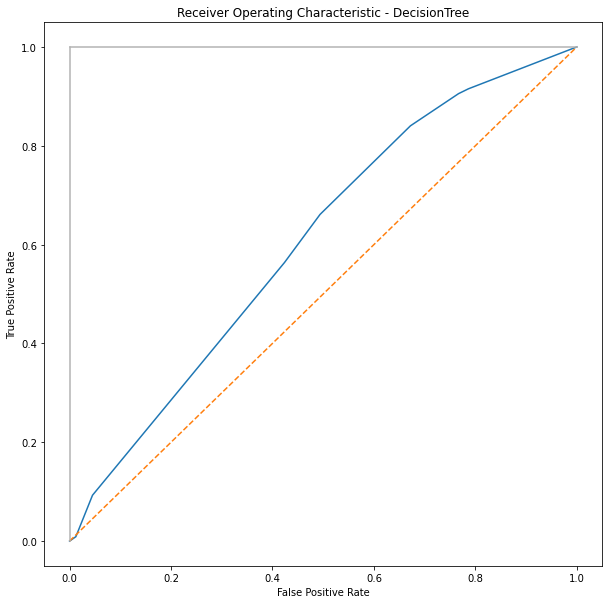

In [37]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XGBoost Model

In [38]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [39]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [1]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [41]:
#prediction and Classification Report

train_model = model.fit(X_train, y_train)
pred1 = train_model.predict(X_test)

print('Model 1 XGboost Report %r' % (classification_report(y_test, pred1)))

Model 1 XGboost Report '              precision    recall  f1-score   support\n\n           0       0.59      0.57      0.58      1128\n           1       0.58      0.59      0.59      1121\n\n    accuracy                           0.58      2249\n   macro avg       0.58      0.58      0.58      2249\nweighted avg       0.58      0.58      0.58      2249\n'


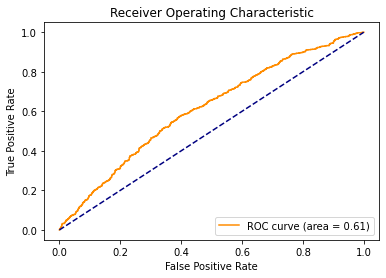

In [42]:

# Generate predicted probabilities on test data
y_pred_prob = model.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Random Forest Model

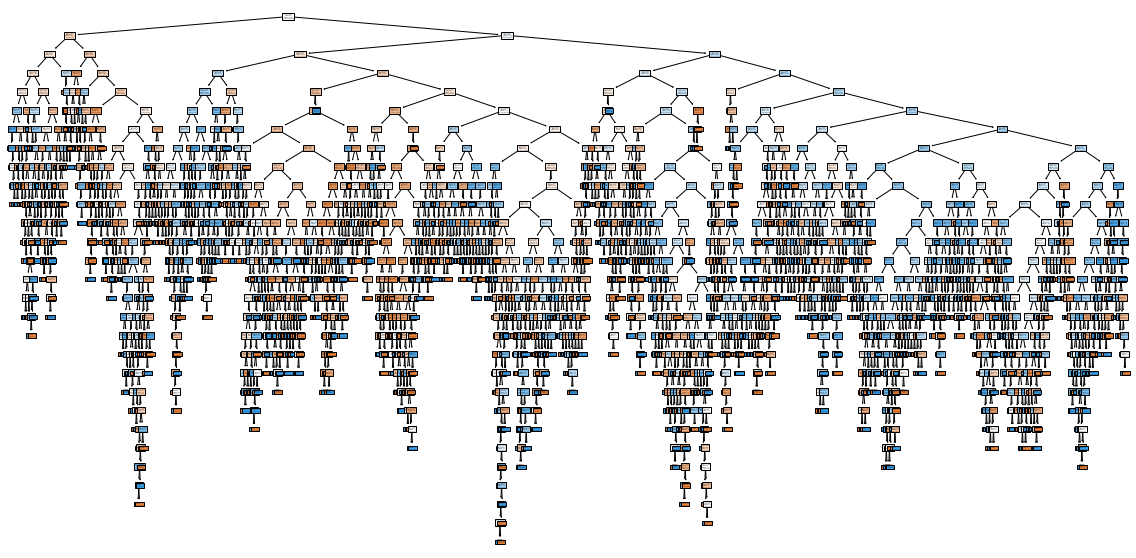

In [43]:
#Generate a random classification dataset
#X_train, y_train = make_classification(n_samples=1000,n_classes=2, random_state=42)

# Fit a Random Forest model to the data
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(X_train, y_train)

# Plot the first tree in the Random Forest
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[0], filled=True)
plt.show()

In [44]:
model = RandomForestClassifier(random_state = 321)

In [45]:
paramGrid = {'n_estimators': [10, 100, 250, 500, 1000], 
             'max_features': ['sqrt', None]}

In [46]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(model, 
                      paramGrid, 
                      cv = 10, 
                      scoring = 'balanced_accuracy', 
                      n_jobs = -1)

In [47]:
searchFit = search.fit(X_train, y_train)

In [48]:
pd.DataFrame(searchFit.cv_results_).sort_values('rank_test_score')[['param_n_estimators', 'param_max_features', 'mean_test_score', 'rank_test_score']].head()

,param_n_estimators,param_max_features,mean_test_score,rank_test_score
6,100,None,0.580145,1
4,1000,sqrt,0.577088,2
9,1000,None,0.576124,3
1,100,sqrt,0.575961,4
3,500,sqrt,0.574803,5


In [49]:
searchFit.best_estimator_

RandomForestClassifier(max_features=None, random_state=321)

In [50]:
testPredictions = searchFit.predict(X_test)

In [51]:
X_test.shape

(2249, 18)

In [52]:
X_train.shape

(5247, 18)

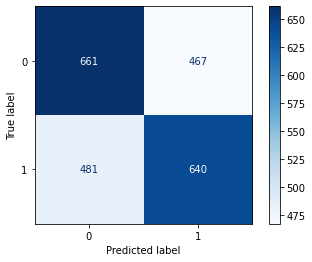

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(searchFit.best_estimator_, 
                                      X_test, 
                                      y_test, 
                                      cmap = plt.cm.Blues);

In [54]:
testPredictionProbs = searchFit.predict_proba(X_test)

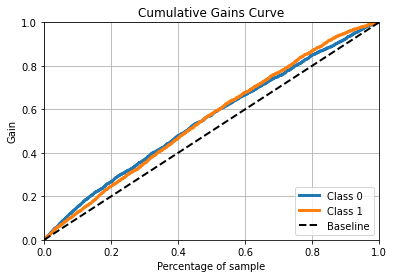

In [55]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, testPredictionProbs);

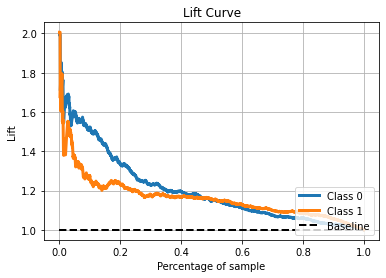

In [56]:
from scikitplot.metrics import plot_lift_curve

plot_lift_curve(y_test, testPredictionProbs);

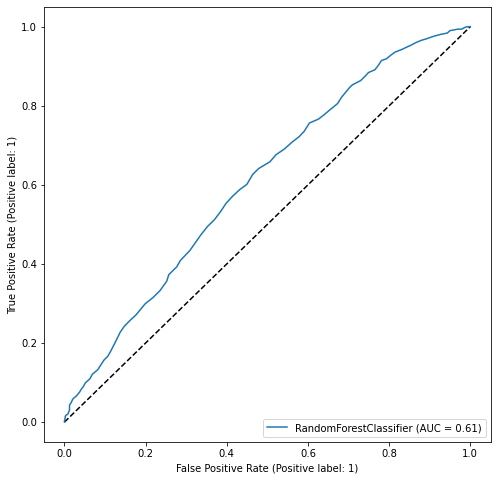

In [57]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize = (8, 8))

ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
RocCurveDisplay.from_estimator(searchFit.best_estimator_, 
                               X = X_test, 
                               y = y_test, 
                               ax = ax);

In [58]:

testPredsCustomCutoff = np.where(testPredictionProbs[:, 1] > 0.26, 1, 0)
testPredsCustomCutoff[:5] # a slice showing the first five values

array([1, 1, 1, 1, 1])

In [59]:
confusion_matrix(y_test, testPredsCustomCutoff)

array([[ 247,  881],
       [  96, 1025]])

In [60]:
accuracy_score(y_test, testPredsCustomCutoff)

0.565584704313028

## Naive Bayes

In [78]:
model = MultinomialNB()

In [79]:
paramGrid = {'fit_prior': [True, False]}

In [80]:
search = GridSearchCV(model,
paramGrid,
cv = 10,
scoring = 'roc_auc')

In [81]:
searchFit = search.fit(X_train, y_train)

In [82]:
pd.DataFrame(searchFit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007567,0.011180,0.003781,0.002553,True,{'fit_prior': True},0.53536,0.581865,0.508751,0.478529,0.517132,0.474893,0.463682,0.498937,0.511552,0.520905,0.509161,0.03235,2
1,0.003483,0.000179,0.002825,0.000274,False,{'fit_prior': False},0.53536,0.581865,0.508809,0.478529,0.517132,0.474893,0.463682,0.498937,0.511552,0.520905,0.509166,0.03235,1


In [ ]:
*******

In [83]:
testPredictions = searchFit.predict(X_test)

In [84]:
testPredictionProbs = searchFit.predict_proba(X_test)

In [85]:
confusion_matrix(y_test, testPredictions)

array([[440, 688],
       [415, 706]])

In [86]:
accuracy_score(y_test, testPredictions)

0.5095598043574923

In [87]:
accuracy = accuracy_score(y_test,yPred)
report = classification_report(yPred, y_test)
cm = confusion_matrix(y_test, yPred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)



Classification report:
Accuracy:  0.5700311249444198
              precision    recall  f1-score   support

           0       0.58      0.57      0.57      1139
           1       0.56      0.57      0.57      1110

    accuracy                           0.57      2249
   macro avg       0.57      0.57      0.57      2249
weighted avg       0.57      0.57      0.57      2249

Confusion matrix:
[[650 478]
 [489 632]]


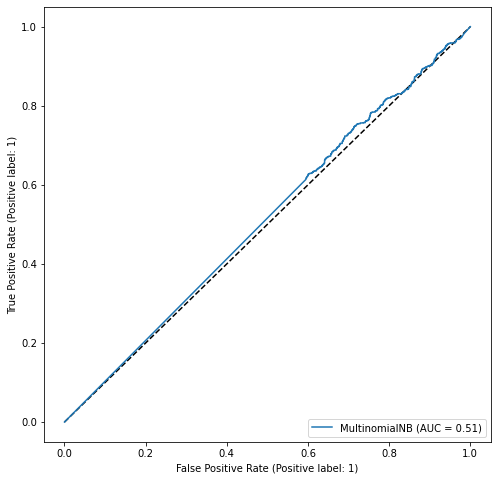

In [88]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
RocCurveDisplay.from_estimator(searchFit.best_estimator_,
X = X_test,
y = y_test,
ax = ax);